## Source Code

The CVSearch class constructs a grid solver which accepts a model and a parameter grid (dictionary
of parameter: value_list, pairs) upon instantiation, following SciKit API conventions. It exposes
the fit method which performs fold generation and search across the parameter grid, returning
a list containing the average of the model’s scoring function on all five folds for each parameter
combination.

The LogisticRegression class constructs a model, also following SciKit conventions, which provides
the fit, score, and predict methods. The LogisticRegression class accepts the optional named
parameter lambda_ and alpha on instantiation, defaulting to 10e-3 and 10e-6 respectively.

In [1]:
import pandas as pd
import numpy as np
from random import uniform
import matplotlib.pyplot as plt
from random import randrange
from copy import deepcopy
from math import copysign
from itertools import combinations, product
from collections import defaultdict
from math import log
from scipy.special import expit

In [2]:
# center/scale each column
def standardize(X, mu=None, sigma=None):
    if mu is None or sigma is None:
        for col, mean in X.mean().items():
            if X[col].dtype != np.int32:
                X[col] = (X[col] - mean) / X[col].std()
    elif sigma is None:
        for col in X.columns:
            if X[col].dtype != object:
                X[col] = (X[col] - mu) / X[col].std()
    elif mu is None:
        for col, mean in X.mean().items():
            if X[col].dtype != object:
                X[col] = (X[col] - mean) / sigma
    else:
        for col in X.columns:
            if X[col].dtype != object:
                X[col] = (X[col] - mu) / sigma
                
    return X

def categorical_cross_entropy(B, X, Y):
    U = expit(np.matmul(X, B))
    P = U/U.sum(axis=1, keepdims=True)
    P_log = np.log(P)
    return -np.diag(np.matmul(P_log, Y.T)).sum() / X.shape[0]

In [3]:
class LogisticRegression:
    terms = np.array([])
    lambda_ = np.nan
    alpha = np.nan
    params = {"lambda_": lambda_, "alpha": alpha}
    
    def __init__(self, lambda_=10e-3, alpha=10e-6):
        self.lambda_ = lambda_
        self.alpha = alpha
        self.X = np.array([])
        self.y_true = np.array([])
        self.params = {"lambda_": self.lambda_, "alpha": self.alpha}
        self.verbose = False
        
    def fit(self, X, y_true):
        self.X = X
        self.y_true = y_true
        p = X.shape[1]-1
        k = y_true.shape[1]
        
        self.terms = np.zeros((p+1, k))
        terms_prev = np.ones((p+1, k))
        
        iters = 10000
        i = 0
        
        while not np.array_equal(terms_prev, self.terms) and i < iters:
            terms_prev = self.terms.copy()

            U = expit(np.matmul(X, self.terms))
            P = U/U.sum(axis=1, keepdims=True)

            Z = self.terms.copy()
            Z[1:, :] = 0

            diff = self.terms - Z
            diff2 = self.y_true - P
            self.terms = self.terms + self.alpha*(np.matmul(X.T, diff2) - 2*self.lambda_*diff)

            i += 1

        if self.verbose: print(f"{i} iters completed ")
            
    def predict(self, X):
        U = expit(np.matmul(X, self.terms))
        P = U/U.sum(axis=1, keepdims=True)
        return P, P.argmax(axis=1)
    
    def score(self, X, y_true):
        return categorical_cross_entropy(self.terms, X, y_true)

In [4]:
class CVSearch:
    """Grid solver for models supporting fit and score methods, following SciKit API conventions."""
    constructor = None
    n_folds = 0
    fold_size = 0
    
    def __init__(self, model_constructor, params, n_folds=5, verbose=False):
        self.constructor = model_constructor
        self.n_folds = n_folds
        self.folds = []
        self.params = params
        self.cat_idxs = []
        self.verbose = verbose
        
    def get_folds(self, X, y_true):
        X_folds = []
        y_true_folds = []
        
        if X.shape[0] != y_true.shape[0]:
            if self.verbose: print("unequal row count between data and labels")
            return False
        
        self.fold_size = X.shape[0]//self.n_folds
        shapes = np.ndarray((self.n_folds,))
        
        if self.verbose: print(f"performing {self.n_folds}-fold CV with {self.fold_size} observations a fold")
        for i in range(self.n_folds):
            # slicing dataset on calculated fold indices
            start = i*self.fold_size
            end = (i+1)*self.fold_size
            
            y_true_folds.append(y_true[start:end])
            X_folds.append(X[start:end])
            shapes[i] = end-start # filling verification arr
            
        # organizing folds
        for i in range(len(X_folds)):
            X_copy = deepcopy(X_folds)
            y_copy = deepcopy(y_true_folds)
            X_holdout = X_copy.pop(i)
            y_holdout = y_copy.pop(i)
            
            # stack
            X_copy, y_copy = np.concatenate(X_copy), np.concatenate(y_copy)
            
            # normalize folds
            mus = [col.mean() for col in X_copy.T]
            sigmas = [col.std() for col in X_copy.T]
            for col, mu, sigma in zip(range(X.shape[1]), mus, sigmas):
                
                if not sigma:
                    X_holdout[:,col] = 0
                    X_copy[:,col] = 0
                else:
                    if col not in self.cat_idxs:
                        X_holdout[:,col] = (X_holdout[:,col]-mu)/sigma
                        X_copy[:,col] = (X_copy[:,col]-mu)/sigma

            self.folds.append(((X_copy, y_copy), (X_holdout, y_holdout)))
            
        # confirming fold size equivalence (400%5==0)
        if not (shapes == self.fold_size).all():
            if self.verbose: print("warning: not all folds of equal size")
                
    def search(self):
        grid = list(self.params.values())
        first = grid.pop(0)
        grid_tups_list = [product(other, first) for other in grid]
        
        param_names = list(self.params.keys())
        first_param_name = param_names.pop(0)
        
        model_param_names = self.constructor.params.keys()
        
        grid_param_list = [(param_name, first_param_name) for param_name in param_names]
        
        for grid_tups, param_names in zip(grid_tups_list, grid_param_list):
            param1, param2 = param_names
            
            if param1 not in model_param_names or param2 not in model_param_names:
                if self.verbose: print(f"param {param1} or {param2} not in model {self.model}")
            else:
                if self.verbose: print(f"Searching parameter {param2} against {param1}-", end="")
                    
                scores = defaultdict(lambda: [])
                first = True
                for value_tup in grid_tups:
                    value1, value2 = value_tup
                    
                    # output
                    if self.verbose:
                        if first:
                            first = False
                            print(f"{value1}:")
                        print("{}: {:G}: ".format(param2, value2))
                        
                    model = self.constructor(**{param1: value1, param2:value2})
                    
                    fold_scores = []
                    i = 1
                    
                    for test, validation in self.folds:
                        if self.verbose: print(f"fold {i}:", end=" ")
                        model.fit(*test)
                        score = model.score(*validation)
                        fold_scores.append(score)
                        i += 1
                        
                    avg_score = np.mean(fold_scores)
                    scores[value1].append(avg_score)
                    
                    if self.verbose: print("score: {:G}".format(avg_score), end="\n\n")
                        
        return scores
    
    def fit(self, X, y_true):
        cat_idxs = []
        for i, dtype in enumerate(X.dtypes):
            if dtype == np.int32:
                cat_idxs.append(i)
                
        self.cat_idxs = cat_idxs
        self.get_folds(X.to_numpy(), y_true.to_numpy())
        return self.search()

In [5]:
df_train = pd.read_csv("data/TrainingData_N183_p10.csv")
df_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274,African
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274,African
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274,African
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274,African
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274,African


In [6]:
df_test = pd.read_csv("data/TestData_N111_p10.csv")
df_test.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,2.517683,5.464283,9.067873,-4.965928,-0.741937,0.039785,0.573279,-0.216918,2.454823,-0.671274,Unknown
1,6.077012,1.032867,-5.795883,-3.490064,-0.600204,-0.120803,1.243767,1.821390,-1.173053,2.442467,Unknown
2,1.016945,-2.913299,0.907702,1.233580,-1.983452,1.605964,2.674998,-0.732921,-2.157438,-0.671274,Unknown
3,-10.860926,2.545077,0.023950,-1.474450,0.372286,-2.609954,-2.794092,1.264747,-3.974644,-0.671274,Unknown
4,4.790262,3.621650,-1.442221,5.459907,-0.864235,-2.591185,-0.062762,0.515344,0.228729,-0.671274,Unknown


In [7]:
raw_y_true = df_train.Ancestry
raw_y_true_test = df_test.Ancestry

# drop labels
raw_train_X = df_train.drop("Ancestry", axis=1)
raw_test_X = df_test.drop("Ancestry", axis=1)

raw_train_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274


In [ ]:
X = standardize(raw_train_X)

# insert biases
X.insert(0, "Bias", np.zeros(len(df_train)))
raw_test_X.insert(0, "Bias", np.zeros(len(df_test)))
raw_train_X.insert(0, "Bias", np.zeros(len(df_train)))

X.head()

In [12]:
uniques = raw_y_true.unique()

Y = pd.DataFrame(np.zeros((X.shape[0], uniques.shape[0])), dtype=np.float64)

for class_, row_idx in zip(raw_y_true, Y.index):
    class_idx = list(uniques).index(class_)
    Y.iat[row_idx, class_idx] = 1
    
# confirm structure
print(np.all(Y.sum(axis=1) == 1))
Y

True


,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
178,0.0,0.0,0.0,0.0,1.0
179,0.0,0.0,0.0,0.0,1.0
180,0.0,0.0,0.0,0.0,1.0
181,0.0,0.0,0.0,0.0,1.0


In [13]:
#alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
samples = 100
lambdas = np.logspace(-2, 6, samples)
#lambdas = [10E-4, 10E-3, 10E-2, 10E-1, 10E0, 10E1, 10E2, 10E3, 10E4]
alpha = 10E-6

terms_list = []
for curr_lambda_ in lambdas:
    model = LogisticRegression(lambda_=curr_lambda_, alpha=alpha)
    model.fit(X.to_numpy(), Y.to_numpy())
    print("Lambda: {:G} Categorical Cross Entropy: {:G}".format(curr_lambda_,model.score(X.to_numpy(), Y.to_numpy())), end="\n\n")
    terms_list.append(model.terms)

Lambda: 0.01 Categorical Cross Entropy: 0.52097

Lambda: 0.012045 Categorical Cross Entropy: 0.52103

Lambda: 0.0145083 Categorical Cross Entropy: 0.521103

Lambda: 0.0174753 Categorical Cross Entropy: 0.52119

Lambda: 0.021049 Categorical Cross Entropy: 0.521295

Lambda: 0.0253536 Categorical Cross Entropy: 0.521422

Lambda: 0.0305386 Categorical Cross Entropy: 0.521575

Lambda: 0.0367838 Categorical Cross Entropy: 0.521759

Lambda: 0.0443062 Categorical Cross Entropy: 0.52198

Lambda: 0.053367 Categorical Cross Entropy: 0.522246

Lambda: 0.0642807 Categorical Cross Entropy: 0.522568

Lambda: 0.0774264 Categorical Cross Entropy: 0.522954

Lambda: 0.0932603 Categorical Cross Entropy: 0.52342

Lambda: 0.112332 Categorical Cross Entropy: 0.52398

Lambda: 0.135305 Categorical Cross Entropy: 0.524655

Lambda: 0.162975 Categorical Cross Entropy: 0.525468

Lambda: 0.196304 Categorical Cross Entropy: 0.526446

Lambda: 0.236449 Categorical Cross Entropy: 0.527624

Lambda: 0.284804 Categorical 

<ipython-input-3-00e015112552>:38: RuntimeWarning: overflow encountered in multiply
  self.terms = self.terms + self.alpha*(np.matmul(X.T, diff2) - 2*self.lambda_*diff)
<ipython-input-3-00e015112552>:38: RuntimeWarning: invalid value encountered in add
  self.terms = self.terms + self.alpha*(np.matmul(X.T, diff2) - 2*self.lambda_*diff)


Lambda: 107227 Categorical Cross Entropy: NAN

Lambda: 129155 Categorical Cross Entropy: NAN



<ipython-input-3-00e015112552>:30: RuntimeWarning: invalid value encountered in matmul
  U = expit(np.matmul(X, self.terms))


Lambda: 155568 Categorical Cross Entropy: NAN

Lambda: 187382 Categorical Cross Entropy: NAN

Lambda: 225702 Categorical Cross Entropy: NAN

Lambda: 271859 Categorical Cross Entropy: NAN

Lambda: 327455 Categorical Cross Entropy: NAN

Lambda: 394421 Categorical Cross Entropy: NAN

Lambda: 475081 Categorical Cross Entropy: NAN

Lambda: 572237 Categorical Cross Entropy: NAN

Lambda: 689261 Categorical Cross Entropy: NAN

Lambda: 830218 Categorical Cross Entropy: NAN

Lambda: 1E+06 Categorical Cross Entropy: NAN



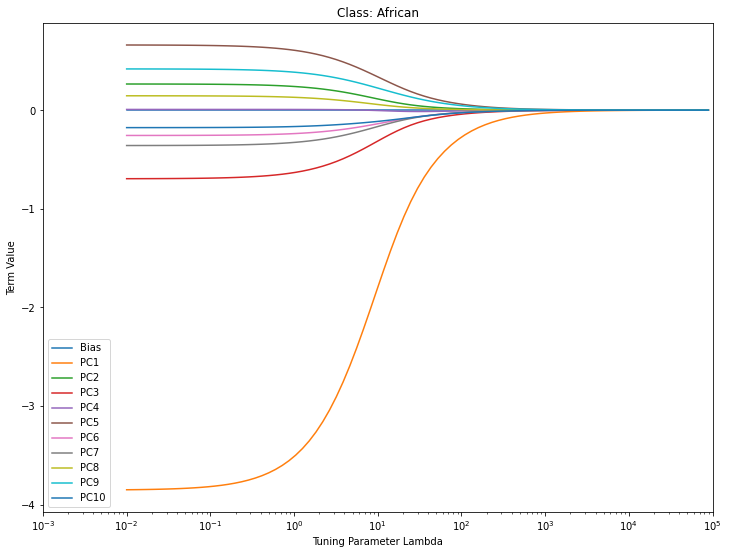

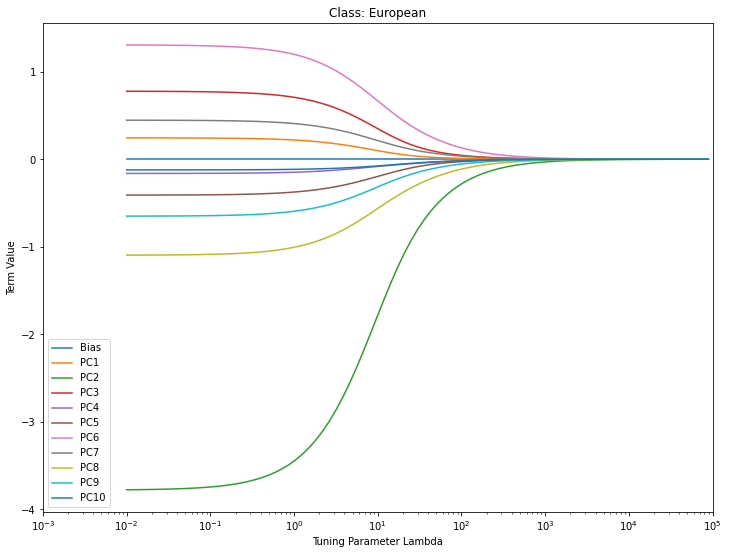

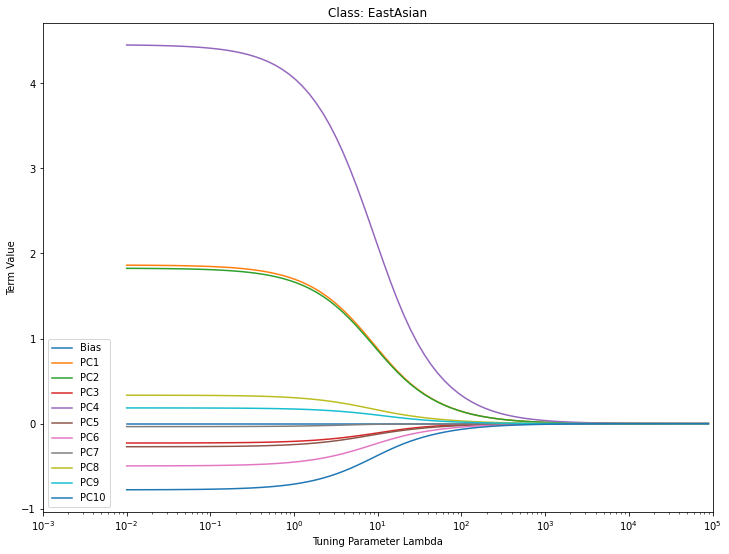

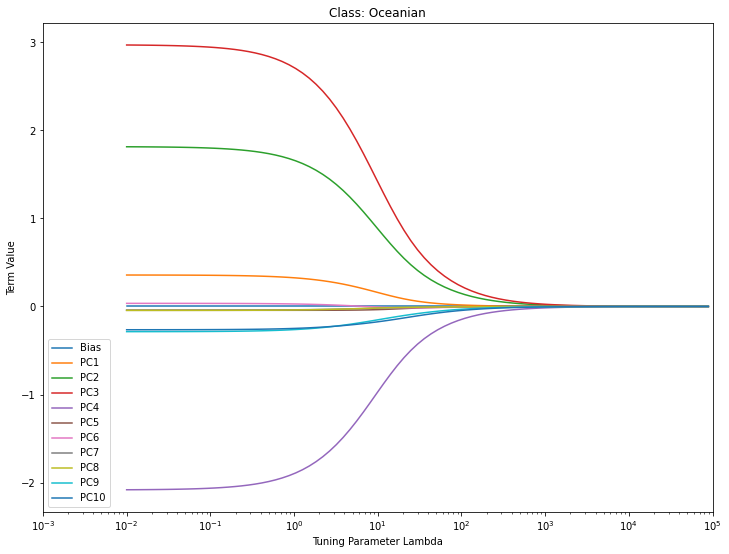

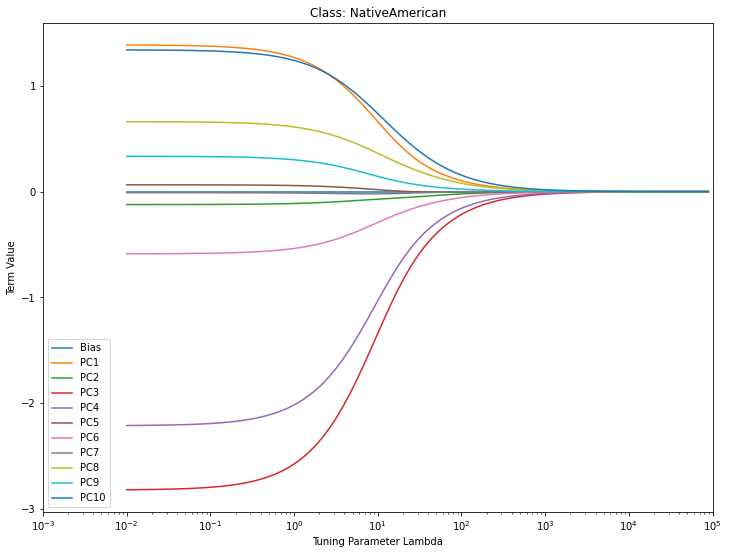

In [14]:
# get rid of biases when plotting
for k in range(len(raw_y_true.unique())):
    terms_k = [terms[:,k] for terms in terms_list]
    plt.figure(figsize=(12,9))
    plt.plot(lambdas, terms_k)
    plt.xscale("log")
    plt.legend(list(X.columns), loc='lower left')
    plt.xlim(10E-4, 10E4)
    plt.ylabel("Term Value")
    plt.xlabel("Tuning Parameter Lambda")
    plt.title(f"Class: {uniques[k]}")
    plt.show()

## CV Error

In [16]:
scores = []

cv = CVSearch(LogisticRegression, {"lambda_": lambdas, "alpha": [10E-6]}, verbose=True)
scores.append(cv.fit(raw_train_X, Y))

for i, dict_ in enumerate(scores.copy()):
    scores[i] = list(dict_.values())

performing 5-fold CV with 36 observations a fold
Searching parameter lambda_ against alpha-1e-05:
lambda_: 0.01: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02218

lambda_: 0.012045: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.0222

lambda_: 0.0145083: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02224

lambda_: 0.0174753: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02227

lambda_: 0.021049: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02232

lambda_: 0.0253536: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02238

lambda_: 0.0305386: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02245

lambda_: 0.0367838: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02253

lambda_: 0.0443062: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02263

lambda_: 0.053367: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02275

lambda_: 0.0642807: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02289

lambda_: 0.0774264: 
fold 1: fold 2: fold 3: fold 4: fold 5: sco

<ipython-input-3-00e015112552>:38: RuntimeWarning: overflow encountered in multiply
  self.terms = self.terms + self.alpha*(np.matmul(X.T, diff2) - 2*self.lambda_*diff)
<ipython-input-3-00e015112552>:38: RuntimeWarning: invalid value encountered in add
  self.terms = self.terms + self.alpha*(np.matmul(X.T, diff2) - 2*self.lambda_*diff)


fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 129155: 
fold 1: 

<ipython-input-3-00e015112552>:30: RuntimeWarning: invalid value encountered in matmul
  U = expit(np.matmul(X, self.terms))


fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 155568: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 187382: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 225702: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 271859: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 327455: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 394421: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 475081: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 572237: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 689261: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 830218: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN

lambda_: 1E+06: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: NAN



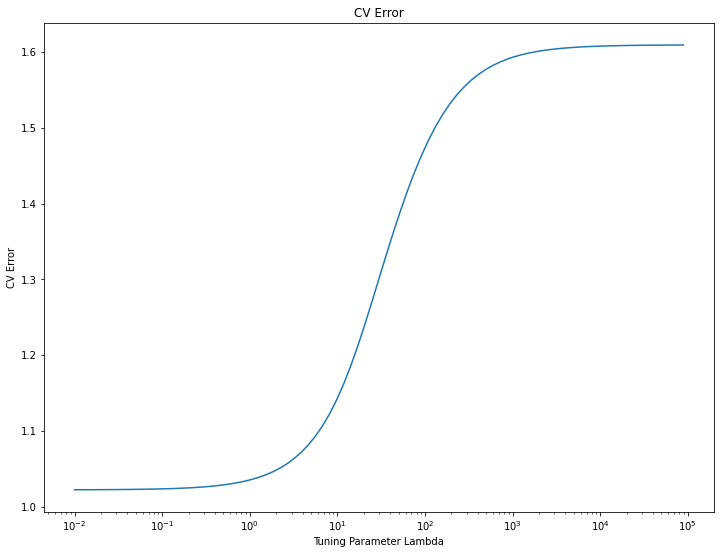

In [17]:
plt.figure(figsize=(12,9))
plt.title("CV Error")
plt.xscale("log")
plt.ylabel("CV Error")
plt.xlabel("Tuning Parameter Lambda")

plt.plot(lambdas, np.squeeze(scores))
plt.show()

## Optimal λ

In [18]:
lambdas = [10E-4, 10E-3, 10E-2, 10E-1, 10E0, 10E1, 10E2, 10E3, 10E4]

scores = []

cv = CVSearch(LogisticRegression, {"lambda_": lambdas, "alpha": [alpha]}, verbose=True)
scores.append(cv.fit(raw_train_X, Y))

for i, dict_ in enumerate(scores.copy()):
    scores[i] = list(dict_.values())
    
errors_list = np.squeeze(scores)
min_idx = np.nanargmin(errors_list)
print(f"\n\nlambda-{lambdas[min_idx]} CCE-{errors_list[min_idx]}")

performing 5-fold CV with 36 observations a fold
Searching parameter lambda_ against alpha-1e-05:
lambda_: 0.001: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02206

lambda_: 0.01: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02218

lambda_: 0.1: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.02336

lambda_: 1: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.03513

lambda_: 10: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.14296

lambda_: 100: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.47385

lambda_: 1000: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.59301

lambda_: 10000: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.60776

lambda_: 100000: 
fold 1: fold 2: fold 3: fold 4: fold 5: score: 1.61055



lambda-0.001 CCE-1.0220582976516468


## Model Parameter Estimates

In [19]:
model = LogisticRegression(lambda_=lambdas[min_idx], alpha=10E-6)
model.fit(X.to_numpy(), Y.to_numpy())
P, pred_idxs = model.predict(raw_test_X.to_numpy())

pred = np.array([uniques[idx] for idx in pred_idxs])

df_P = pd.DataFrame(P)
df_P["Pred"] = pred[:, np.newaxis]
df_P["True"] = raw_y_true_test

df_P.columns = [*uniques, "Pred", "True"]

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df_P

,African,European,EastAsian,Oceanian,NativeAmerican,Pred,True
0,0.000,0.000,0.000,1.000,0.000,Oceanian,Unknown
1,0.000,0.001,0.081,0.002,0.917,NativeAmerican,Unknown
2,0.000,0.549,0.439,0.011,0.001,European,Unknown
3,0.501,0.000,0.000,0.499,0.000,African,Unknown
4,0.000,0.000,0.766,0.001,0.233,EastAsian,Unknown
5,0.000,0.467,0.000,0.000,0.533,NativeAmerican,Mexican
6,0.000,0.447,0.000,0.027,0.526,NativeAmerican,Mexican
7,0.000,0.458,0.048,0.001,0.493,NativeAmerican,Mexican
8,0.001,0.378,0.006,0.000,0.614,NativeAmerican,Mexican
9,0.000,0.496,0.007,0.000,0.497,NativeAmerican,Mexican


## Classification Analysis

For every observation labeled as African American in the test dataset the multinomial logistic
regression model gave a classification of African, which suggests a large amount of overlap in genetic
data between the two. This makes sense given America’s history in the slave trade where roughly 10
million slaves were forcibly transported to the new world[1] between the 16th and 19th centuries.

The model’s consistency in classification demonstrates a one-to-one relationship between African
ancestry and African American ancestry.

Demonstrating a more complex relationship is the Mexican ancestry, which the model classified
as European and Native American. One instance was narrowly classified as Oceanian, with a one-thousandth higher class probability for Oceanian over Native American ancestry, which should not
be dismissed. Further examination of predicted class probabilities for Native Americans instances
shows reasonably high probabilities for the Oceanian ancestry, which can be explained by recent
studies published on the diversity of Native American ancestral populations showing a link between
Amazonian Native Americans and Polynesians[2]. The European and Native American predictions
clearly show the immigration waves from Spain beginning with the Spanish conquest of the Aztec
Empire in the 16th century. Seeing as the indigenous Mexicans were Native Americans it is apparent
why these classifications are made, including those of Oceanian ancestry.

[1]Curtin, The Atlantic Slave Trade, 1972, p. 88. 

[2]Skoglund, P., Mallick, S., Bortolini, M. et
al. Genetic evidence for two founding populations of the Americas. Nature 525, 104–108 (2015).
https://doi.org/10.1038/nature14895

## SciKit Implementation

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

samples = 100
lambdas = np.logspace(-2, 6, samples)
terms_list = []

for curr_lambda_ in lambdas:
    model = LogisticRegression(C=1/curr_lambda_)
    model.fit(X.to_numpy(), raw_y_true.to_numpy())
    score = model.score(X.to_numpy(), raw_y_true.to_numpy())
    print("Lambda: {:G}\n CCE: {:G}".format(curr_lambda_, score), end="\n\n")
    terms_list.append(model.coef_)

Lambda: 0.01
 CCE: 1

Lambda: 0.012045
 CCE: 1

Lambda: 0.0145083
 CCE: 1

Lambda: 0.0174753
 CCE: 1

Lambda: 0.021049
 CCE: 1

Lambda: 0.0253536
 CCE: 1

Lambda: 0.0305386
 CCE: 1

Lambda: 0.0367838
 CCE: 1

Lambda: 0.0443062
 CCE: 1

Lambda: 0.053367
 CCE: 1

Lambda: 0.0642807
 CCE: 1

Lambda: 0.0774264
 CCE: 1

Lambda: 0.0932603
 CCE: 1

Lambda: 0.112332
 CCE: 1

Lambda: 0.135305
 CCE: 1

Lambda: 0.162975
 CCE: 1

Lambda: 0.196304
 CCE: 1

Lambda: 0.236449
 CCE: 1

Lambda: 0.284804
 CCE: 1

Lambda: 0.343047
 CCE: 1

Lambda: 0.413201
 CCE: 1

Lambda: 0.497702
 CCE: 1

Lambda: 0.599484
 CCE: 1

Lambda: 0.722081
 CCE: 1

Lambda: 0.869749
 CCE: 1

Lambda: 1.04762
 CCE: 1

Lambda: 1.26186
 CCE: 1

Lambda: 1.51991
 CCE: 1

Lambda: 1.83074
 CCE: 1

Lambda: 2.20513
 CCE: 1

Lambda: 2.65609
 CCE: 1

Lambda: 3.19927
 CCE: 1

Lambda: 3.85353
 CCE: 1

Lambda: 4.64159
 CCE: 1

Lambda: 5.59081
 CCE: 1

Lambda: 6.73415
 CCE: 1

Lambda: 8.11131
 CCE: 1

Lambda: 9.7701
 CCE: 1

Lambda: 11.7681
 CCE:

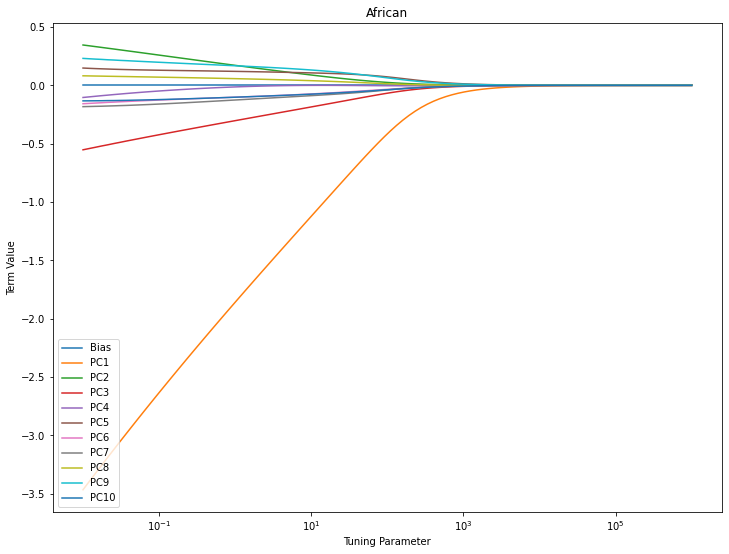

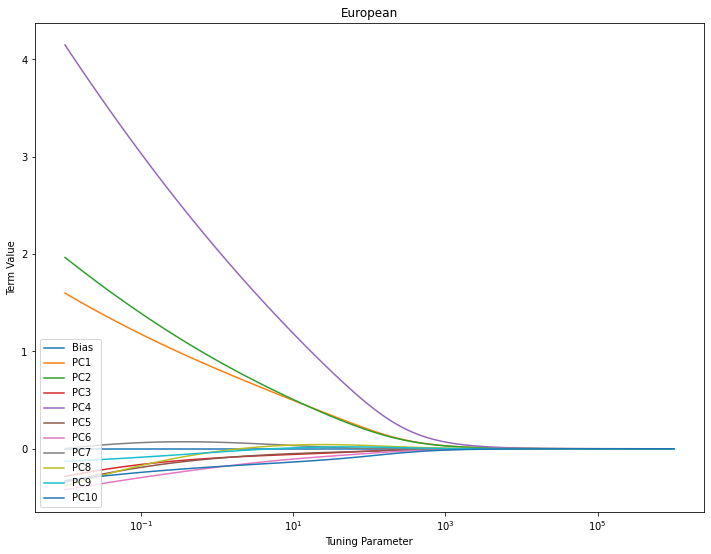

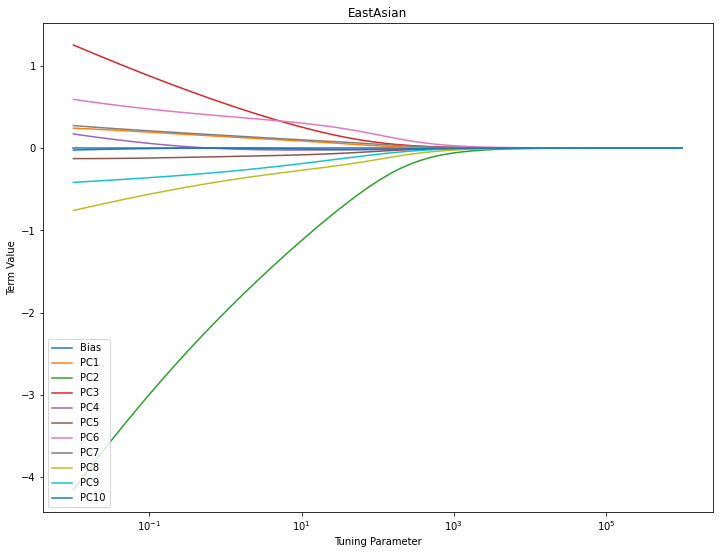

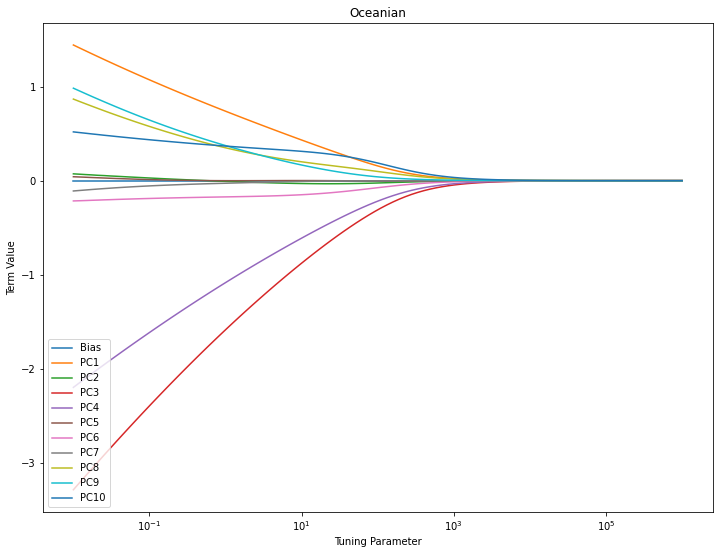

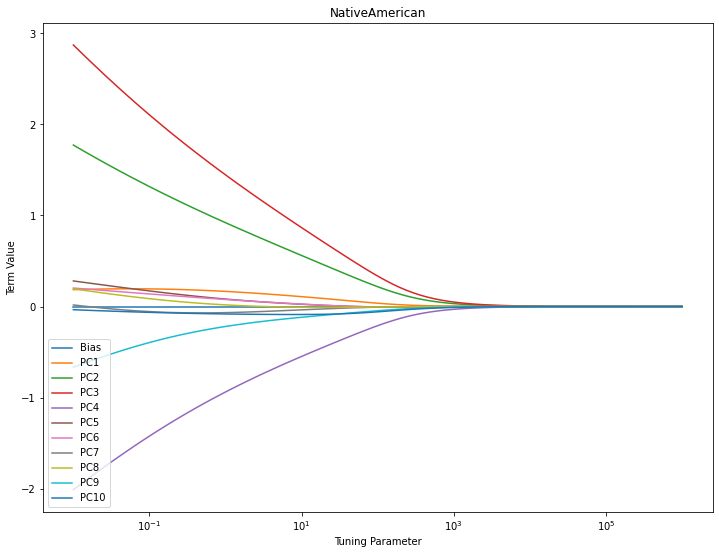

In [22]:
for k in range(uniques.shape[0]):
    plt.figure(figsize=(12,9))
    a = [terms[k,:] for terms in terms_list]
    plt.plot(lambdas, a)
    plt.xscale("log")
    plt.legend(list(X.columns), loc='lower left')
    plt.ylabel("Term Value")
    plt.xlabel("Tuning Parameter")
    plt.title(f"{uniques[k]}")
    plt.show()

In [24]:
lambdas = np.logspace(-2, 6, 100)
#lambdas = np.array([10E-4, 10E-3, 10E-2, 10E-1, 10E0, 10E1, 10E2, 10E3, 10E4])
scores = []

cv = LogisticRegressionCV(cv=5, Cs=1/lambdas)
cv.fit(X, raw_y_true)
values = list(cv.scores_.values())

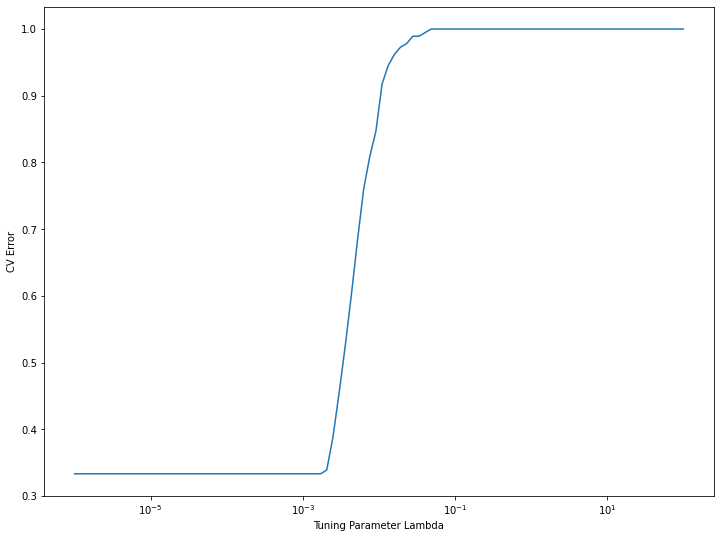

In [25]:
#averaging results of fold scores together
acc = np.zeros((len(values), len(lambdas)), dtype=np.float64)
for k in range(len(values)):
    acc += values[k]
    
acc = acc/len(values)
scores_sci = acc.sum(axis=0)/5

plt.figure(figsize=(12,9))
plt.plot(1/lambdas, scores_sci)
plt.ylabel("CV Error")
plt.xlabel("Tuning Parameter Lambda")
plt.xscale("log")
plt.show()

In [26]:
min_idx = np.argmin(scores_sci)
print(f"lambda-{1/lambdas[min_idx]} Score-{scores_sci[min_idx]}")

lambda-0.0017073526474706885 Score-0.3333333333333333


The observed optimal λ value for the SciKit implementation is 10e-3 , with a score of 1/3 averaged
across all folds.

In [27]:
lambda_ = 10E-3
model = LogisticRegression(C=1/lambda_)
model.fit(X.to_numpy(), raw_y_true.to_numpy())

P_sci = model.predict_proba(raw_test_X)
pred_sci = model.predict(raw_test_X)

df_P_sci = pd.DataFrame(np.hstack((P_sci, pred_sci[:,np.newaxis], raw_y_true_test[:,np.newaxis])))
df_P_sci.columns = ["African", "EastAsian", "European", "NativeAmerican", "Oceanian", "Pred", "True"]

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_P_sci

,African,EastAsian,European,NativeAmerican,Oceanian,Pred,True
0,0.000,0.000,0.000,0.000,1.000,Oceanian,Unknown
1,0.000,0.000,0.000,1.000,0.000,NativeAmerican,Unknown
2,0.000,0.000,1.000,0.000,0.000,European,Unknown
3,1.000,0.000,0.000,0.000,0.000,African,Unknown
4,0.000,1.000,0.000,0.000,0.000,EastAsian,Unknown
5,0.000,0.000,0.000,1.000,0.000,NativeAmerican,Mexican
6,0.000,0.000,0.000,1.000,0.000,NativeAmerican,Mexican
7,0.000,0.000,0.000,1.000,0.000,NativeAmerican,Mexican
8,0.000,0.000,0.000,1.000,0.000,NativeAmerican,Mexican
9,0.000,0.000,0.002,0.998,0.000,NativeAmerican,Mexican


In [28]:
diff = np.sum([1 if class_ != class_sci else 0 for class_, class_sci in zip(pred, pred_sci)])
print(f"Number of different classifications between models: {diff}")

Number of different classifications between models: 5


## SciKit Implementation Results

Although the models demonstrated very different class probabilities for instances, actual classifications were very similar with only four differing between the two. When comparing probabilities,
the SciKit model was much more confident with many 100% class probabilities, suggesting a more
well fit model. This could be due to the early stopping behavior in the SciKit model.

CV error showed a much faster growth and convergence to maximum error in the SciKit model.
This could be due to how the SciKit CVGrid scores itself, which is difficult to expose and emulate
due to the large amount of processing done with the data